# Importing Libraries

In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install spacy
import numpy as np
import pandas as pd
import csv
import keras
import sklearn
import random
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
import io
import string
#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS
#from spacy.lang.en import English
#import en_core_web_sm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import seaborn as sns

Using TensorFlow backend.


# Data Exploration

In [2]:

print ("Reading text data for classification and building representations...")
df = pd.read_excel ("C:\\Users\\v-savrav\\Text\\data\\datasetv1.xlsx")

Reading text data for classification and building representations...


In [3]:
df.columns

Index(['PrimaryTopic', 'secondarytopic', 'Description'], dtype='object')

# Input: 'Description'
# Output :'PrimaryTopic'

In [4]:
df['secondarytopic'].value_counts()

Invoice Payment Status                                 20215
Email Invoice and Refund Submission                    11801
Others                                                  5349
Expense Report Submission Query                         4580
Travel and Expenses Status                              3521
SAP Flow                                                3496
Payment Action                                          2793
Education on Vendor, Categories and Process             2708
Audit and Policy Violation Notification                 2545
User Education on Tool and Process                      2508
Invoice Change Request                                  2488
Employee Account Maintenance and Status Query           2451
Reporting Request                                       2319
MPC - Payee Account Maintenance                         1898
Bank                                                    1818
Statement of Account Request                            1304
Other Actions SAP       

In [99]:
vc=df['secondarytopic'].value_counts()
u  = [i not in set(vc[vc<1000].index) for i in df['secondarytopic']]
df = df[u]


In [105]:
df['id'].value_counts()

2     19989
10    11643
9      5332
11     4023
7      3449
6      3291
4      2779
17     2642
8      2542
13     2447
1      2393
14     2320
0      2255
15     1876
18     1817
3      1291
16     1153
12     1084
5      1020
Name: id, dtype: int64

# Removing NULL records

In [102]:
from io import StringIO
df = df[pd.notnull(df['Description'])]
df = df[pd.notnull(df['secondarytopic'])]

In [103]:
df

,PrimaryTopic,secondarytopic,Description
2,AP Reporting Request,Reporting Request,"PO re-opened Hi Team, Kindly note that PO 009..."
6,Payee Account Management,Employee Account Maintenance and Status Query,"Hello Prohelp, Please send the DOCUSIGN link ..."
7,Invoice Management,Invoice Payment Status,"Hola, Se puede usar la tarjeta de MS para p..."
8,Invoice Management,Invoice Payment Status,Talebiniz bize ulasti Degerli Müsterimiz...
9,Invoice Management,Statement of Account Request,QVR 1086 - Austria
11,Disbursement,Payment Action,"Hi Team, Please note thatBangladesh bank file..."
12,Payee Account Management,Employee Account Maintenance and Status Query,"Hello AP Team, Based on the below supplier unb..."
14,MyOrder Requisition Request,PO Status Request,Asked for an approval
15,Invoice Management,Invoice Payment Status,"Hi Team, Good day! We have resubmitted the b..."
16,Invoice Management,Statement of Account Request,Accounts Payable Reconciliation - 2297780 - Pr...


# Factorising the Primary Topic to ID

In [104]:
df['id'] = df['secondarytopic'].factorize()[0]
category_id_df = df[['secondarytopic', 'id']].drop_duplicates().sort_values('id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['id', 'secondarytopic']].values)
df.head()

,PrimaryTopic,secondarytopic,Description,id
2,AP Reporting Request,Reporting Request,"PO re-opened Hi Team, Kindly note that PO 009...",0
6,Payee Account Management,Employee Account Maintenance and Status Query,"Hello Prohelp, Please send the DOCUSIGN link ...",1
7,Invoice Management,Invoice Payment Status,"Hola, Se puede usar la tarjeta de MS para p...",2
8,Invoice Management,Invoice Payment Status,Talebiniz bize ulasti Degerli Müsterimiz...,2
9,Invoice Management,Statement of Account Request,QVR 1086 - Austria,3


In [106]:
id_to_category

{0: 'Reporting Request',
 1: 'Employee Account Maintenance and Status Query',
 2: 'Invoice Payment Status',
 3: 'Statement of Account Request',
 4: 'Payment Action',
 5: 'PO Status Request',
 6: 'Travel and Expenses Status',
 7: 'SAP Flow',
 8: 'Audit and Policy Violation Notification',
 9: 'Others',
 10: 'Email Invoice and Refund Submission',
 11: 'Expense Report Submission Query',
 12: 'Approver Activities Change Approver',
 13: 'Invoice Change Request',
 14: 'User Education on Tool and Process',
 15: 'MPC - Payee Account Maintenance',
 16: 'Other Actions SAP',
 17: 'Education on Vendor, Categories and Process',
 18: 'Bank'}

# Imbalanced Classes
We see that the number of complaints per product is imbalanced. Consumers’ complaints are more biased towards 
Invoice Management, Payee Account Management and Travel and Expenses Management.


However, in our case of learning imbalanced data, the majority classes might be of our great interest. It is desirable to have a classifier that gives high prediction accuracy over the majority class, while maintaining reasonable accuracy
for the minority classes. Therefore, we will leave it as it is.

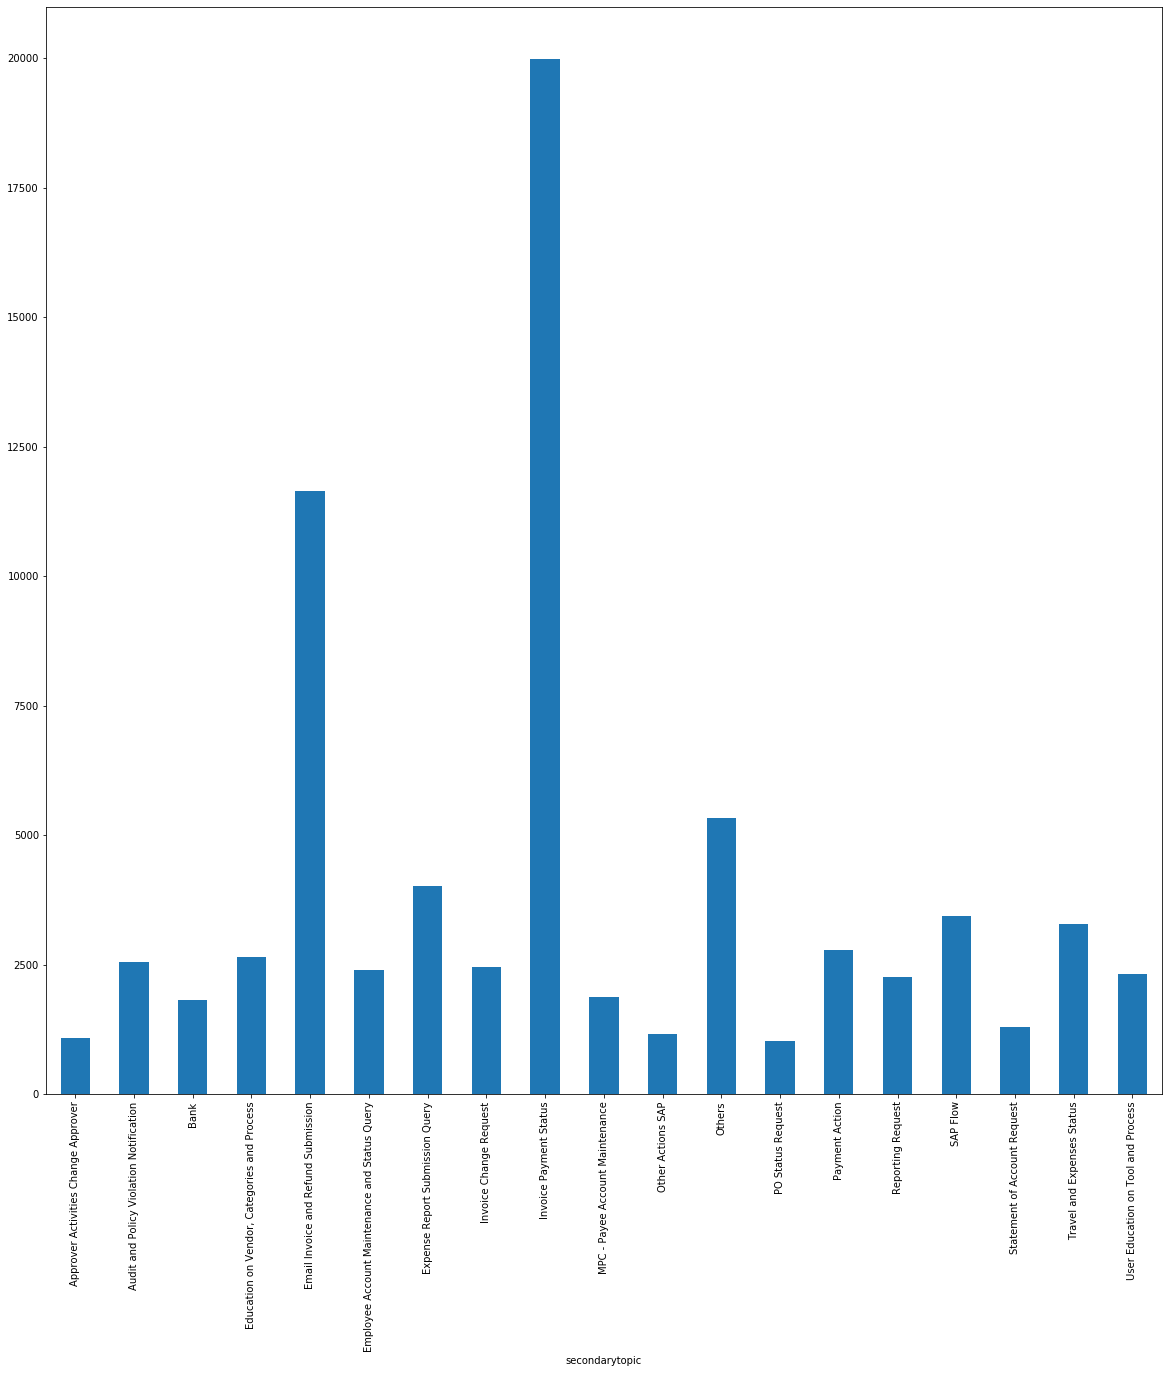

In [107]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
df.groupby('secondarytopic').Description.count().plot.bar(ylim=0)
plt.show()

In [108]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
#is based on The Porter Stemming Algorithm
stopwords = stopwords.words("english")
snowball_stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\v-savrav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [109]:
df=df.dropna()
df['Description']=df['Description'].astype(str)
df=df.reset_index()
# tokenization 
tokenized_doc = df['Description'].apply(lambda x: x.split())

# remove stop-words 

tokenized_doc = tokenized_doc.apply(lambda x: [wordnet_lemmatizer.lemmatize(item) for item in x if item not in stopwords])
#tokenized_doc = tokenized_doc.apply(lambda x: [snowball_stemmer.stem(item) for item in x ])
# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df['Description'] = detokenized_doc

In [110]:
import string

def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

df['Description'] = df['Description'].apply(remove_punctuation)

# Text Representation

In [111]:
from sklearn.feature_extraction.text import HashingVectorizer
vector = HashingVectorizer(decode_error = 'ignore',
                          n_features = 2**21,
                          preprocessor = None,
                           encoding='utf-8',lowercase=True, ngram_range=(1,1))

In [112]:
X = vector.fit_transform(df['Description'])
print(X.shape)
labels = df.id

(73346, 2097152)


In [174]:
df=df[['id','Description']]

In [175]:
X=df['Description']
y=df['id']

In [176]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, df.index, test_size=0.30, random_state=0)


In [177]:
def tweetGenerator(df):
    """
    This function takes a tweet from the data frame
    and returns the text of the tweet as well as the sentiment label
    """
    for row in df.itertuples():
        label = row[1]
        tweet = row[2]
        yield tweet, label

In [178]:
tweet_gen = tweetGenerator(df)

In [179]:
tweet_gen

<generator object tweetGenerator at 0x000001C8BF4369A8>

In [180]:
def getBatch(tweet_gen, size):
    """
    This function takes as arguments
    the tweet generator tweet_gen and the batch size
    desired. It returns two lists for the tweets and labels
    whose length is the batch size
    """
    tweets, labels = [], []
    for _ in range(size):
        tweet, label = next(tweet_gen)
        tweets.append(tweet)
        labels.append(label)
    return tweets, labels

In [153]:
clf = SGDClassifier(loss='log')

In [57]:
from sklearn.linear_model import SGDClassifier
SGDclassifier = SGDClassifier(loss='log', random_state=1)
tweet_gen = tweetGenerator(df)

In [39]:
from sklearn.naive_bayes import BernoulliNB
BernoulliNBclassifier = BernoulliNB(alpha = 0.01)
tweet_gen = tweetGenerator(df)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
MNBclassifier = MultinomialNB()
tweet_gen = tweetGenerator(df)

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
PassiveAggressive = PassiveAggressiveClassifier(C=1.0, fit_intercept=True, shuffle=True)
tweet_gen = tweetGenerator(df)


In [183]:
import pyprind
batchSize = 5000
totalTweets = len(df)
#totalTweets = 15000
iterations = int(totalTweets/batchSize)
progressBar = pyprind.ProgBar(iterations)

classes = np.unique(y)


In [184]:
len(df['id'].value_counts())

19

In [186]:
for i in range(iterations):
    X_train, y_train = getBatch(tweet_gen, size=batchSize)
    X_train = vector.transform(X_train)
    #MNBclassifier.partial_fit(X_train, y_train, classes=classes)
    #BernoulliNBclassifier.partial_fit(X_train, y_train, classes=classes)
    #SGDclassifier.partial_fit(X_train, y_train, classes=classes)
    clf.partial_fit(X_train, y_train, classes=classes)
    #PassiveAggressive.partial_fit(X_train, y_train, classes=classes)
    progressBar.update()

0% [##############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:14


In [187]:
#tweet_gen_test = tweetGenerator(df_test)
#X_test, y_test = getBatchTest(tweet_gen_test, size=df_test.shape[0])
X_test = vector.transform(X_test)

In [188]:
X_train.shape

(5000, 2097152)

In [189]:
X_test.shape

(22004, 2097152)

In [190]:
print('Accuracy: %.3f' %  SGDclassifier.score(X_test, y_test))

NotFittedError: This SGDClassifier instance is not fitted yet

In [191]:
print('Accuracy: %.3f' %  clf.score(X_test, y_test))

Accuracy: 0.604


In [ ]:
print('Accuracy: %.3f' % BernoulliNBclassifier.score(X_test, y_test))

# Prediction 

# Confusion Matrix
   The vast majority of the predictions end up on the diagonal (predicted label = actual label), where we want them to be. However, there are a number of misclassifications,and it might be interesting to see what those are caused by:

In [ ]:
from sklearn.externals import joblib
filename = 'sgd_model.sav'
joblib.dump(SGDclassifier, filename)
filename = 'clf_model.sav'
joblib.dump(clf, filename)

In [ ]:
filename = 'clf_model.sav'
joblib.dump(clf, filename)

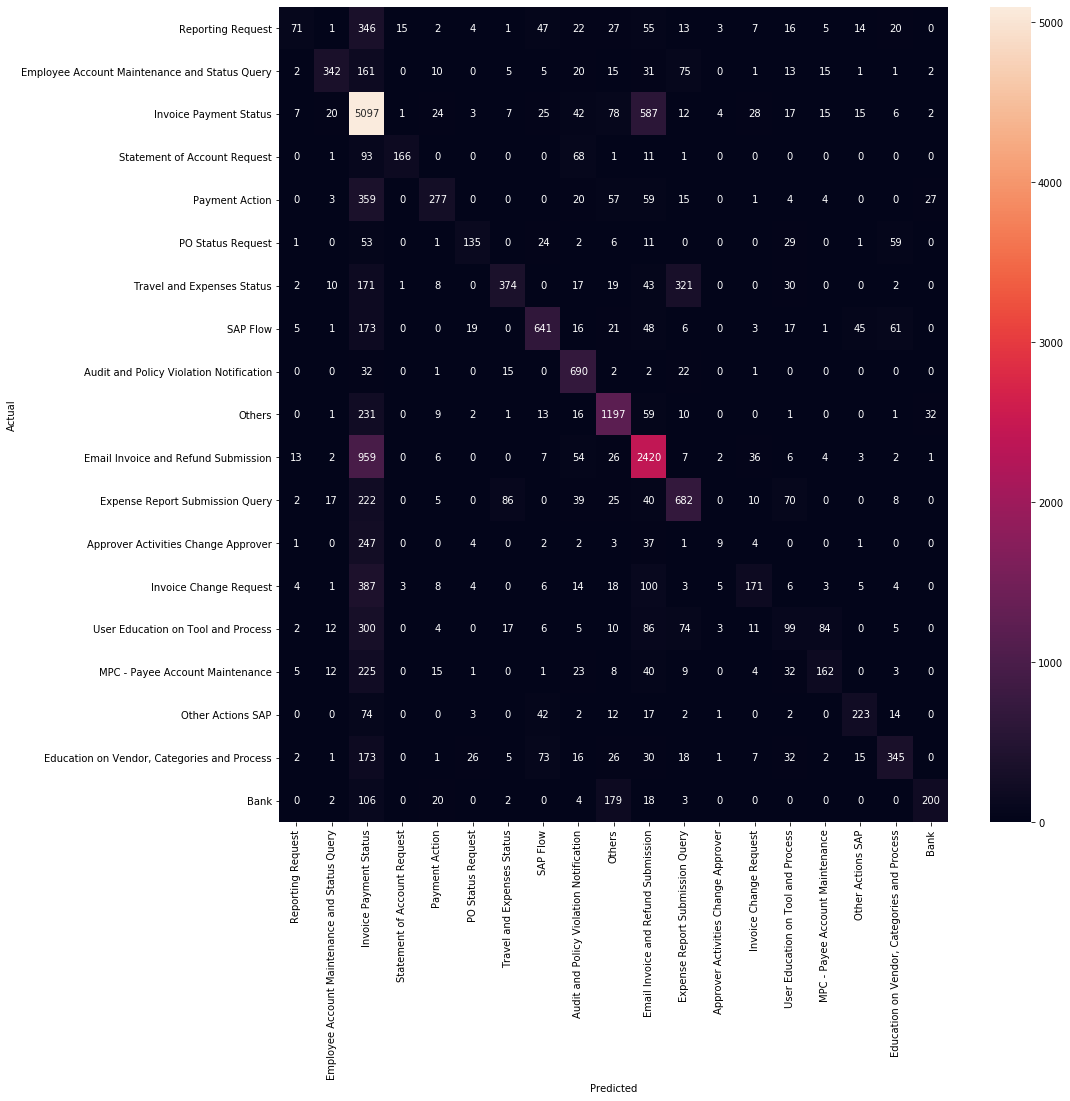

In [193]:
#model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
#model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.secondarytopic.values, yticklabels=category_id_df.secondarytopic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#  SGD classifier Report

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['secondarytopic'].unique()))

In [ ]:
y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.PrimaryTopic.values, yticklabels=category_id_df.PrimaryTopic.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# clf report

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['PrimaryTopic'].unique()))

In [96]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

from parfit import bestFit
import parfit as pf

model =SGDClassifier()
grid ={ 
'alpha' : [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4], #learning rate 
#epoch
'loss'  : ['log'], #logistic regression 
'penalty':['l2'], 
'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)


for i in range(iterations):
    X_train, y_train = getBatch(tweet_gen, size=batchSize)
    X_train = vector.transform(X_train)
    bestModel, bestScore = pf.bestFit(model, paramGrid, X_train, y_train,
                                                        metric = roc_auc_score, greater_is_better = True, scoreLabel = "AUC")

    
    progressBar.update()

-------------CROSS-VALIDATING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:    3.7s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:    3.7s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    3.7s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:    3.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:    3.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    3.7s remaining:    0.0s


IndexError: too many indices for array